<H1>Relationship between IL and price change in a stableswap pool</H1>


In [1]:
import sys
import os
import glob
import random
import copy
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'USDA': {'usd price': 1, 'weight': 0.51},
    'USDB': {'usd price': 1, 'weight': 0.49}
}

assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 1000000

initial_state = GlobalState(
    pools={
        'stableswap': StableSwapPoolState(
            tokens={
                tkn: initial_tvl * assets[tkn]['weight'] for tkn in assets
            },
            amplification=1000,
            trade_fee=0
        )
    },
    agents = {
        'LP': Agent(
            holdings={'USDA': 5100, 'USDB': 4900},
            trade_strategy=invest_all('stableswap')
        ),
        'Trader': Agent(
            holdings={tkn: 10000000000000 for tkn in assets}
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # archive_all=False
)


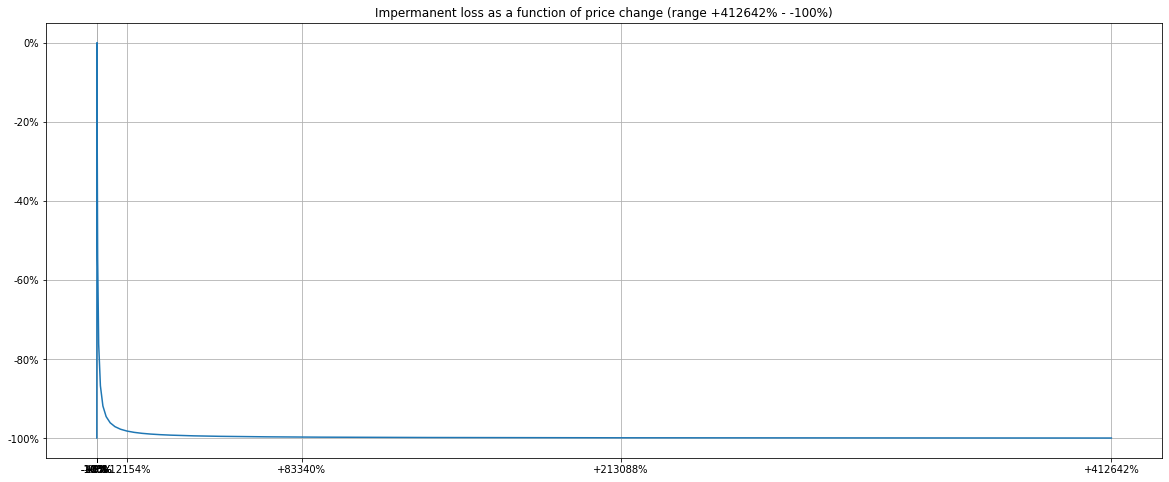

In [2]:
steps = 201
# price_min = 0.2
# price_max = 5
trade_size_min, trade_size_max = -1000000, 1000000
step_factor = (trade_size_max / trade_size_min) ** (1 / (steps - 1))
trade_sizes = [trade_size_min + i * (trade_size_max - trade_size_min) / steps for i in range(steps)]
# [-trade_size_min * step_factor ** i for i in range(steps)][::-1] + [trade_size_min * step_factor ** i for i in range(steps)]
events = []

initial_holdings = copy.deepcopy(initial_state.agents['LP'].holdings)
initial_trader_holdings = copy.deepcopy(initial_state.agents['Trader'].holdings)
first_state = initial_state.copy()

for trade_size in trade_sizes:

    events.append(
        run.run(initial_state, time_steps=1, silent=True)[-1].execute_swap(
            pool_id='stableswap',
            agent_id='Trader',
            tkn_sell='USDA' if trade_size > 0 else 'USDB',
            tkn_buy='USDB' if trade_size > 0 else 'USDA',
            sell_quantity=max(abs(trade_size), 0),
        )
    )

usda_prices = [
    1 / event.pools['stableswap'].spot_price
    for event in events
]

usdb_prices = [
    event.pools['stableswap'].spot_price
    for event in events
]

d_list = []
for event in events:
    ss = event.pools['stableswap']
    d_list.append(ss.calculate_d())

for event in events:
    StableSwapPoolState.execute_remove_uniform(
        state=event.pools['stableswap'],
        agent=event.agents['LP'],
        shares_removed=event.agents['LP'].holdings['stableswap']
    )

asset_value = [
    value_assets(prices={'USDA': usda_prices[i], 'USDB': 1}, assets=event.agents['LP'].holdings)
    for i, event in enumerate(events)
]

deposit_value = [
    value_assets(prices={'USDA': usda_prices[i], 'USDB': 1}, assets=initial_holdings)
    for i, event in enumerate(events)
]

asset_value_2 = [
    value_assets(prices={'USDB': usdb_prices[i], 'USDA': 1}, assets=event.agents['LP'].holdings)
    for i, event in enumerate(events)
]

deposit_value_2 = [
    value_assets(prices={'USDB': usdb_prices[i], 'USDA': 1}, assets=initial_holdings)
    for i, event in enumerate(events)
]

# agent_funds = [
#     event.cash_out(event.agents['LP'])
#     for i, event in enumerate(events)
# ]

impermanent_loss = [
    asset_value[i] / deposit_value[i] - 1
    for i, event in enumerate(events)
]

impermanent_loss_2 = [
    asset_value_2[i] / deposit_value_2[i] - 1
    for i, event in enumerate(events)
]

agent_value = [
    value_assets(
        prices={
            'USDA': usda_prices[i]
        }, 
        assets=initial_holdings
    ) - 1
    for i in range(len(events))
]

plt.figure(figsize=(20, 8))
# plt.xscale('symlog')

# clear default ticks
for t in plt.gca().xaxis.get_minor_ticks():
    t.set_visible(False)

graph_length = len(events)
x_points = 16
x_step = (graph_length - 1) / (x_points - 1)
x_ticks = [usda_prices[int(x_step * i)] for i in range(x_points)]
x_labels = []
for t in x_ticks:
    if t < 1:
        x_labels.append(f'-{round((1 - t) * 100)}%')
    else:
        x_labels.append(f'+{round((t - 1) * 100)}%')
plt.xticks(x_ticks, x_labels)

y_min = round(impermanent_loss[-1] * 100) / 100
y_points = 6
y_step = y_min / (y_points - 1)
y_ticks = [y_min - y_step * i for i in range(y_points)]
y_labels = [f'{round(y * 100)}%' for y in y_ticks]
plt.yticks(y_ticks, y_labels)

plt.grid()
plt.title(f'Impermanent loss as a function of price change (range {x_labels[0]} - {x_labels[-1]})')

# colors = pu.color_gradient(len(events), color1=(255, 128, 0), color2=(0, 0, 255))
# for i in range(len(events)):
plt.plot(usda_prices, impermanent_loss)
# plt.plot(usda_prices, asset_value)
# plt.plot(usda_prices, deposit_value)
# plt.legend([f'{round(weight * 100, 1)}%' for weight in weight_factors])

# plt.figure(figsize=(20, 5))
# plt.plot(range(len(events)), [
#     agent_funds[i] / agent_value[i]
#     for i, event in enumerate(events)
# ])

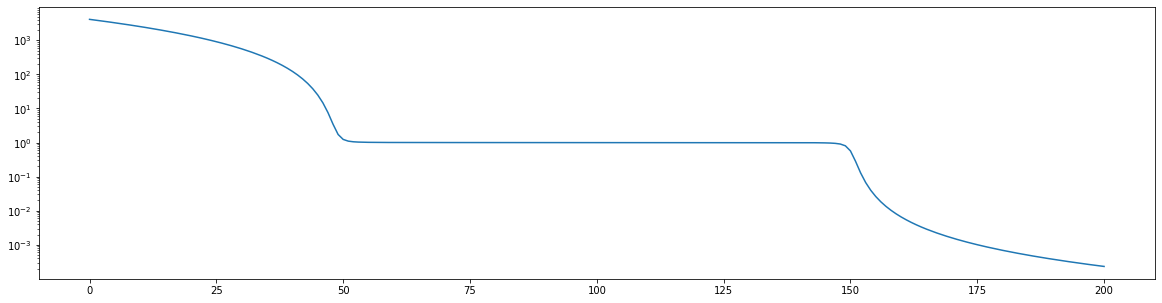

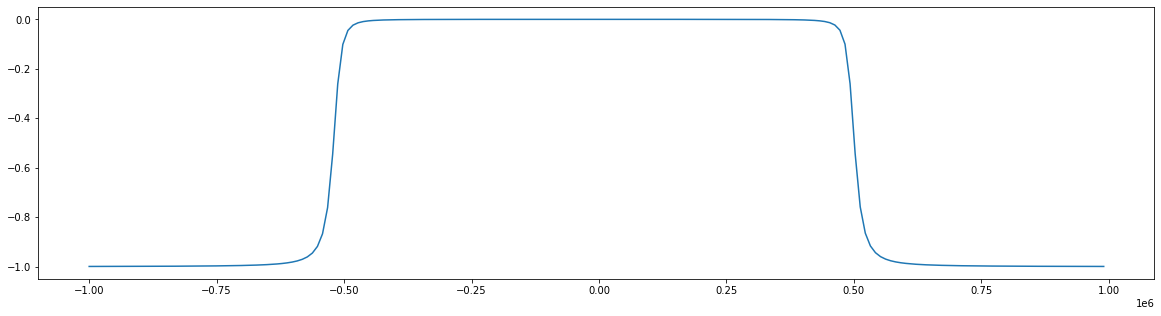

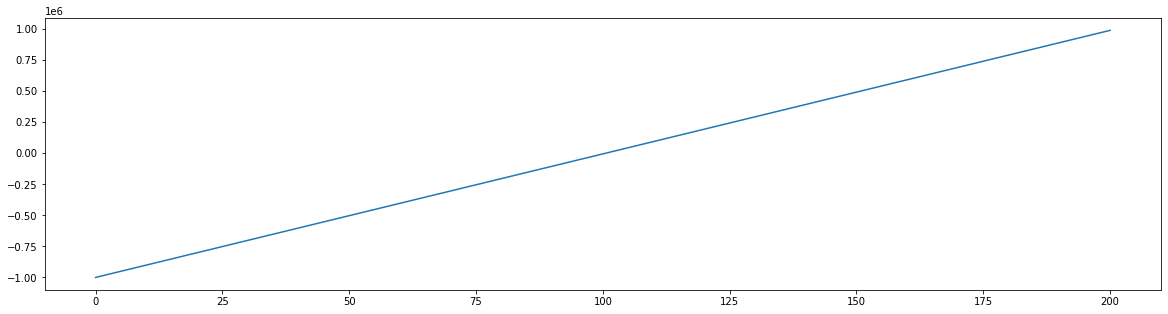

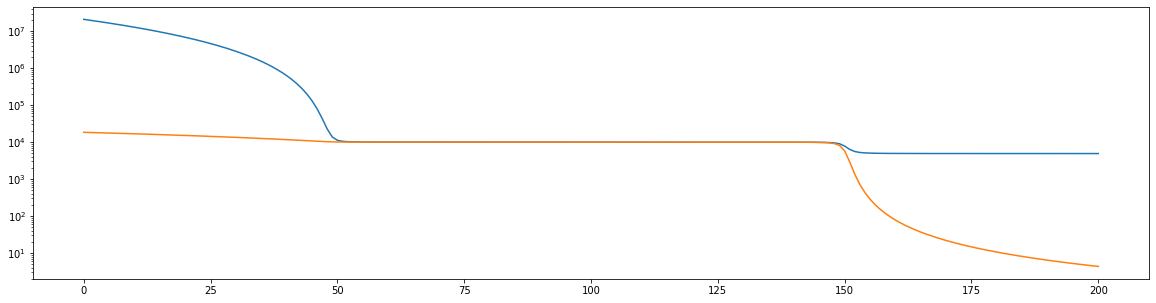

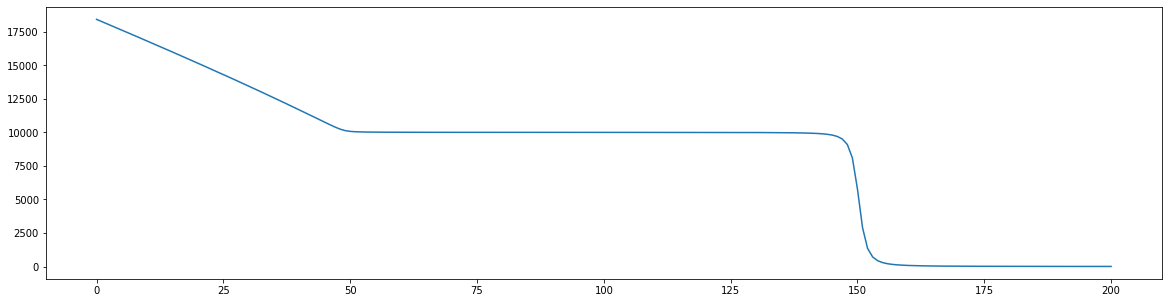

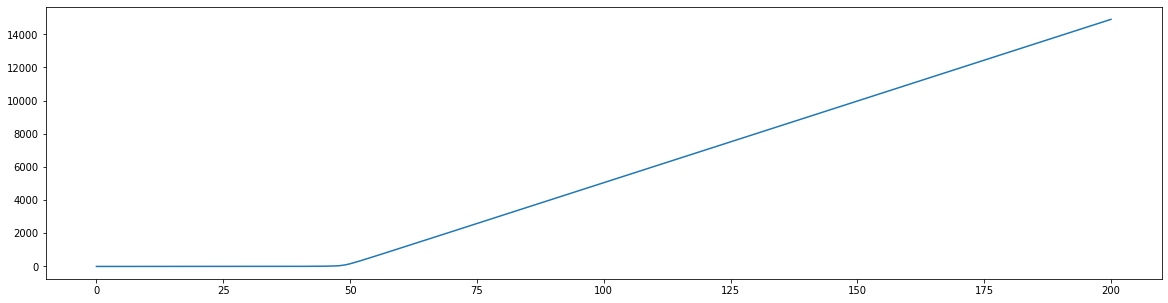

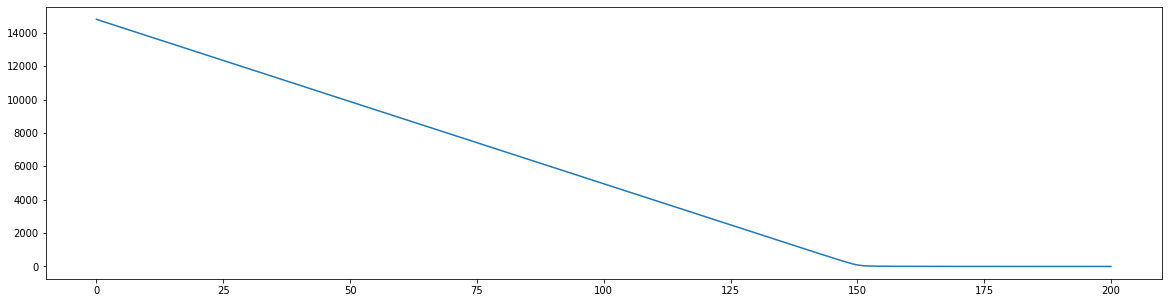

In [3]:
plt.figure(figsize=(20,5))
plt.plot(range(len(events)), usda_prices)
plt.yscale('log')
plt.figure(figsize=(20,5))
plt.plot(trade_sizes, impermanent_loss)
# plt.figure(figsize=(20,5))
# plt.plot(trade_sizes, impermanent_loss_2)
plt.figure(figsize=(20,5))
plt.plot(range(len(events)), trade_sizes)
plt.figure(figsize=(20,5))
plt.plot(range(len(events)), deposit_value)
# plt.figure(figsize=(20,5))
plt.plot(range(len(events)), asset_value)
plt.yscale('log')
plt.figure(figsize=(20,5))
plt.plot(range(len(events)), asset_value)
plt.figure(figsize=(20,5))
plt.plot(range(len(events)), [event.agents['LP'].holdings['USDA'] for event in events])
plt.figure(figsize=(20,5))
plt.plot(range(len(events)), [event.agents['LP'].holdings['USDB'] for event in events])




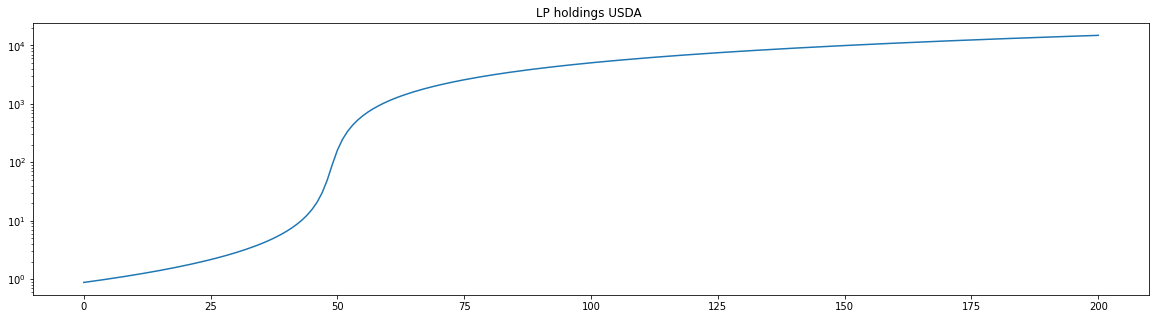

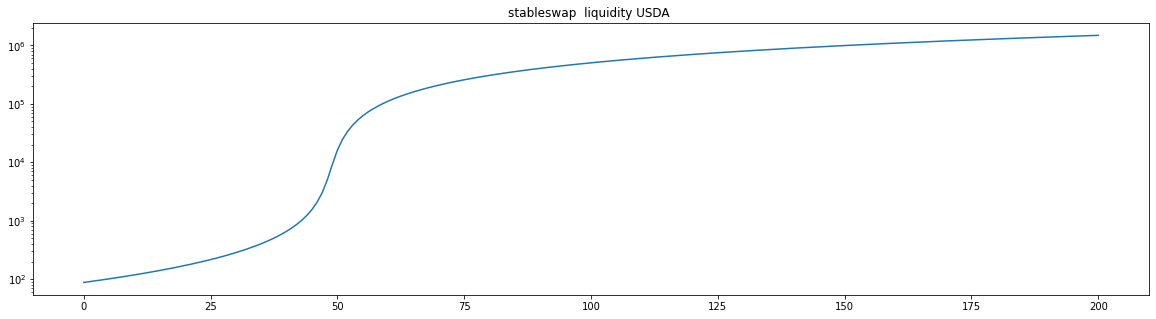

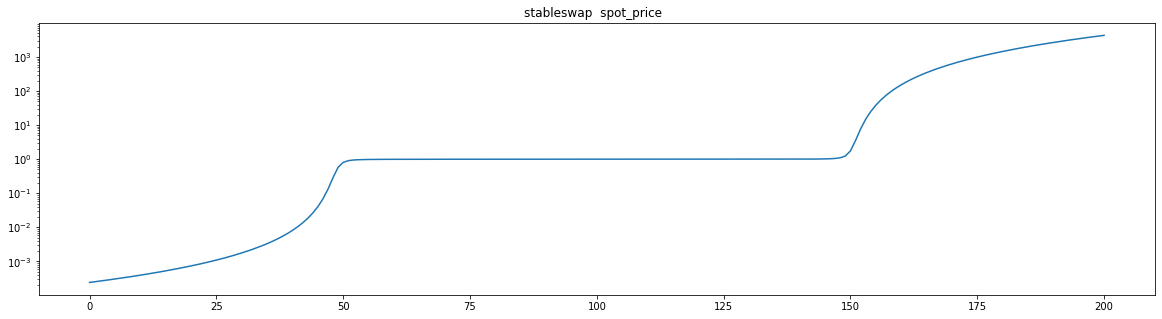

In [4]:
pu.plot(events, agent='LP', prop='holdings', key='USDA')
plt.yscale('log')
pu.plot(events, pool='stableswap', prop='liquidity', key='USDA')
plt.yscale('log')
pu.plot(events, pool='stableswap', prop='spot_price')
plt.yscale('log')

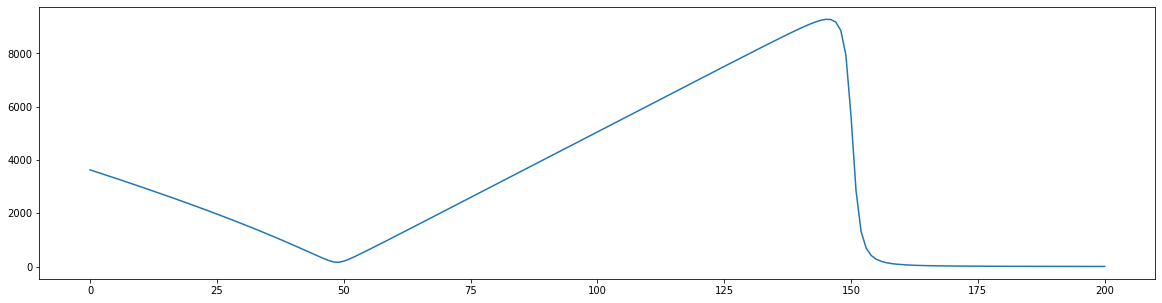

In [5]:
holdings = pu.get_datastream(events, agent='LP', prop='holdings', key='USDA')
price = pu.get_datastream(events, pool='stableswap', prop='spot_price')
plt.figure(figsize=(20, 5))
plt.plot(range(len(events)), [holdings[i] / price[i] for i in range(len(events))])

In [6]:
print(asset_value)

[18428.69403875902, 18268.016062555795, 18107.07460036497, 17945.861539787413, 17784.36843581268, 17622.586494048912, 17460.50655299752, 17298.119065316303, 17135.414078015296, 16972.381211540065, 16809.009637682622, 16645.2880562749, 16481.20467062261, 16316.747161638825, 16151.902660659774, 15986.657720929268, 15820.998287781435, 15654.90966756094, 15488.37649539714, 15321.382701989445, 15153.911479671813, 14985.945248141781, 14817.465620419876, 14648.453369848925, 14478.88839928299, 14308.749714102589, 14138.01540136372, 13966.662618372955, 13794.667595383584, 13622.005659171018, 13448.651287317756, 13274.578207653638, 13099.759564403554, 12924.16818371469, 12747.776989048938, 12570.559646159361, 12392.491566725814, 12213.551485703169, 12033.723982670877, 11853.003609425165, 11671.401861498673, 11488.959428746497, 11305.768814837254, 11122.01875486864, 10938.08838026849, 10754.766702542698, 10573.825817628673, 10399.70039273771, 10244.371932663193, 10132.665524541255, 10075.05906564

In [7]:
print(deposit_value)

[21054766.33912826, 20135048.0057051, 19238927.459438294, 18366187.488642752, 17516611.58792833, 16689983.995530443, 15886089.733108953, 15104714.648106502, 14345645.458828518, 13608669.802604955, 12893576.287113193, 12200154.545193182, 11528195.293451756, 10877490.394881902, 10247832.925923003, 9639017.248217247, 9050839.08561159, 8483095.606648335, 7935585.5132156825, 7408109.1357372, 6900468.535565962, 6412467.615181206, 5943912.236903601, 5494610.350897569, 5064372.133300871, 4653010.13545922, 4260339.445257566, 3886177.8617335004, 3530346.0842207833, 3192667.9174025725, 2872970.493831658, 2571084.5155579653, 2286844.516669483, 2020089.1486484292, 1770661.4905046031, 1538409.3855457613, 1323185.8063007635, 1124849.2481838868, 943264.1503652461, 778301.3375679307, 629838.4657848553, 497760.4295820677, 381959.6251246, 282335.7898000622, 198794.6139710148, 131242.50028335702, 79567.41142057761, 43559.14998346626, 22521.82214240559, 13717.014911705053, 11211.724198774318, 10520.3977365

In [8]:
state = events[-1]
print(initial_holdings)
print(state.agents['LP'].holdings)
print(initial_trader_holdings)
print(state.agents['Trader'].holdings)
print(first_state.pools['stableswap'].liquidity)
print(state.pools['stableswap'].liquidity)

{'USDA': 5100, 'USDB': 4900}
{'USDA': 14902.472784591688, 'USDB': 0.8548879047232046, 'USD': 0, 'stableswap': 0.0}
{'USDA': 10000000000000, 'USDB': 10000000000000}
{'USDA': 9999999009950.248, 'USDB': 10000000494813.656, 'USD': 0}
{'USDA': 510000.0, 'USDB': 490000.0}
{'USDA': 1490247.2784591895, 'USDB': 85.48879047232165}


-2.4279437349505884e-08
-2.4279437349505884e-08


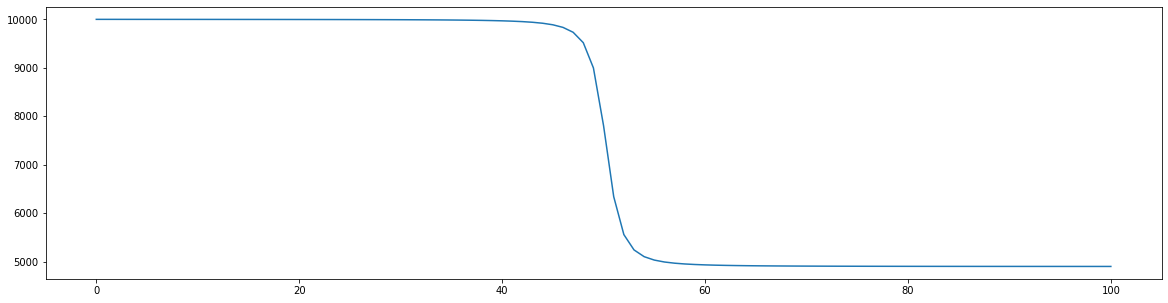

In [9]:
print(max(impermanent_loss))
plt.figure(figsize=(20,5))
plt.plot(range(101), deposit_value[100:])
print(impermanent_loss[100])